<br>

# Introduction

[//]: <> (General idea of this notebook.)
This notebook facilitates using the RiverScape Python package (Straatsma and Kleinhans, 2018) to parameterize and position landscaping measures and update the input data for the two-dimensional (2D) flow model Delft3D Flexible Mesh (DFM). 

[//]: <> (Study area.)
For the current notebook version, we would use the River Waal, which is the main distributary of the River Rhine in the Netherlands.  

[//]: <> (TODO: Add Fig. 3 of Straatsma and Kleinhans, 2018)

[//]: <> (This is also a comment.)


## Requirement (python modules/packages)

To run this notebook, please import the following python modules.

In [1]:
# import standard modules
import os
import sys
import string
import subprocess
import time
import math

# import required modules/packages (which may require installation)
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize

import matplotlib
# %matplotlib notebook
# TODO: Note that pcr.plot() still does not support interactive zoom-ing.

from collections import OrderedDict
import pcraster as pcr

<br>

Please also make sure that this notebook file is in the same folder as the RiverScape Python module files that must be loaded.

In [2]:
# check the content of this folder
!ls

# import RiverScape Python modules
import mapIO
import pcrRecipes
import measures_py3 as msr
from riverscape import *

channel.ipynb		   mapIO.py	    pcrRecipes.py  riverscape
intervent_parameter.ipynb  measures_py3.py  __pycache__


In [3]:
# Most likely, you also have to fix the path. Note that pcraster must always be the first.
os.environ["PATH"] = "/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin"
print(os.environ["PATH"])

# test using aguila
!aguila

# TODO: Investigate why we need this? This should not happen.

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
qt.qpa.xcb: QXcbConnection: XCB error: 145 (Unknown), sequence: 175, resource id: 0, major code: 139 (Unknown), minor code: 20


In [4]:
# check the path and test aguila
# print(os.environ["PATH"])
# test aguila 
# pcr.aguila()
# !aguila

<br>

# Input and output folders

In the following please define the input and output folders. 

In [5]:
# - for test on cartesius
# output_dir  = "/scratch/depfg/sutan101/tmp_menno/out/"
# input_dir   = "/scratch/depfg/hydrowld/river_scape/source/from_menno/riverscape/input/"
# scratch_dir = "/scratch/depfg/sutan101/tmp_menno/tmp/"

# - for test on fleet
output_dir  = "/scratch/sutan101/tmp_menno_test/out/"
input_dir   = "/home/sutan101/data/river_scape/source/from_menno/riverscape/input/"
scratch_dir = output_dir + "/tmp/"

# TODO: Use 'select_directory'.

In [6]:
# You may also wanto set the input_dir, interactively
# input_dir   = select_directory()
# TODO: Check whether we can create the folder use 'select_directory'


<br>

# Start processing/calculation 

To start processing, please load the following cells in order to set and test some basic configuration. 

<br>


In [7]:
# make scratch directory and go to this folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

In [8]:
# set global option for pcraster such that length of cells is computed in true length of cells
pcr.setglobaloption('unittrue')
# TODO: Check with Menno why we need this?

In [9]:
# set the pcraster clone map
current_dir = os.path.join(input_dir, 'reference_maps')
pcr.setclone(os.path.join(current_dir, 'clone.map'))
print(current_dir)

/home/sutan101/data/river_scape/source/from_menno/riverscape/input/reference_maps


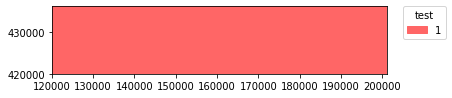

In [10]:
# check and plot the clone map
test = pcr.readmap(os.path.join(current_dir, 'clone.map'))
pcr.plot(test) 

<br>

## Loading input files

By running the following cells, the input files would be read. These input files consist of the following attributes of current/existing condition.

* main_dike: current/existing river embankment properties: 
* minemb: minor embankment properties:
* groyne: groyne properties: 
* hydro: hydrodynamics (delft3d-fm) attributes, e.g. chexy, nikuradse, specific discharge, velocity, water depth, water level, etc.
* mesh: delft3d mesh
* axis: river attributes, e.g. location, radius, turning direction, velocity, water depth, water level, etc. 
* geom:
* lulc:

For further information about them, please check Menno and Kleinhans (2018), see e.g. their Table 2. 

In [11]:
# change to the 'current_dir' (input data) for reading/importing input data
os.chdir(current_dir)
!pwd
#TODO: Check why do we need this? It seems that os.path.join does not work?

/home/sutan101/data/river_scape/source/from_menno/riverscape/input/reference_maps


In [12]:
# reading current/existing river embankment properties for main dikes, minor embankments and groynes 
# - for each, this will return location, length, volume, and height - #TODO: unit is needed here. 
main_dike = msr.read_dike_maps(current_dir, 'main_dike')
minemb    = msr.read_dike_maps(current_dir, 'minemb')
groynes   = msr.read_dike_maps(current_dir, 'groyne')

In [13]:
# reading Hydrodynamics (delft3d-fm) attributes 
# - chezy, nikuradse, specific discharge, velocity, water depth, water level, etc
hydro = msr.read_hydro_maps(current_dir)
# - hydrodynamic mesh
mesh = msr.read_mesh_maps(current_dir)

# TODO: Shall we define plots for hydro and mesh attributes

In [14]:
# reading RiverScape attributes
# - axis: location, radius, turning_direction, rkm, rkm_point, rkm_line, rkm_full
axis = msr.read_axis_maps(current_dir)
# - geometry: clone, dem, distance to main dike, distance to groyne, distance to main channel, 
#            floodplain widths, contiguous narrow floodplain, contiguous wide floodplain
geom = msr.read_geom_maps(current_dir)
# reading land use land cover attribute
lulc = msr.read_lulc_maps(current_dir)

# TODO: Shall we define their plots?

<br>

## Visualizing existing attributes

You may want to check existing attributes by plotting them using the following cells. 


In [15]:
# go to the scratch directory so that all temporary files (e.g. made during aguila) would be stored there 
os.chdir(scratch_dir)

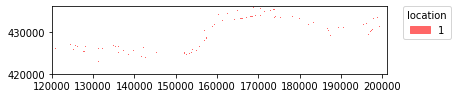

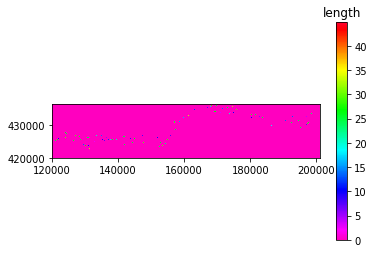

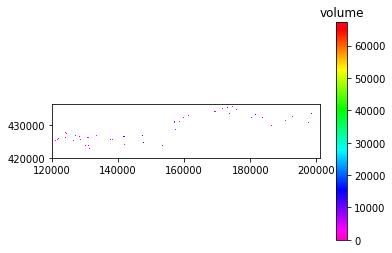

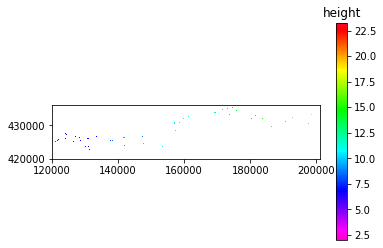

In [16]:
# plot main embankments
main_dike.plot()

In [17]:
# close all aguila processes
!killall aguila

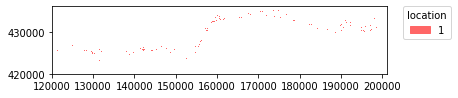

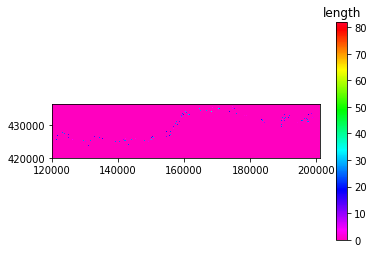

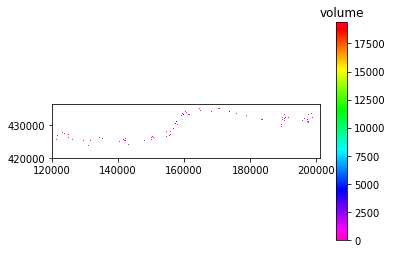

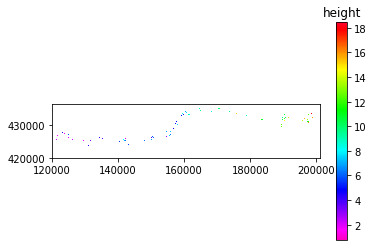

In [18]:
# plot minor embankment
minemb.plot()

In [19]:
# close all aguila processes
!killall aguila

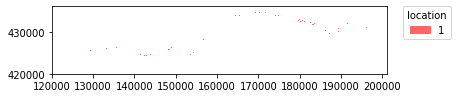

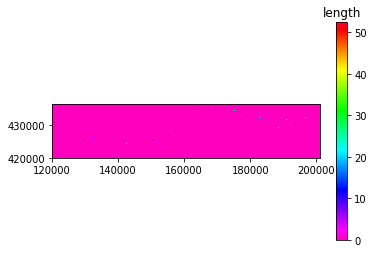

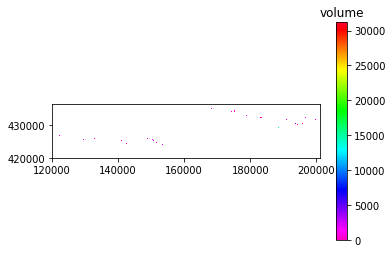

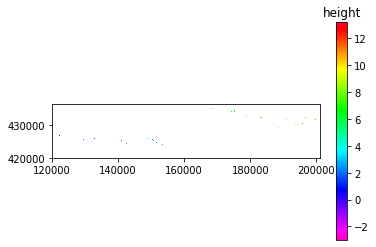

In [20]:
# plot groynes
groynes.plot()

In [21]:
# close all aguila processes
!killall aguila

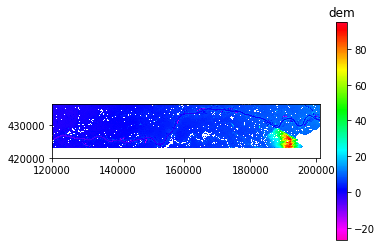

In [22]:
# plot the digital elevation model
pcr.aguila(geom.dem)
dem = geom.dem ; pcr.plot(dem)

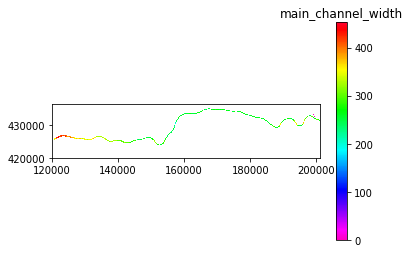

In [23]:
# plot river main channel width
pcr.aguila(geom.main_channel_width)
main_channel_width = geom.main_channel_width ; pcr.plot(main_channel_width)

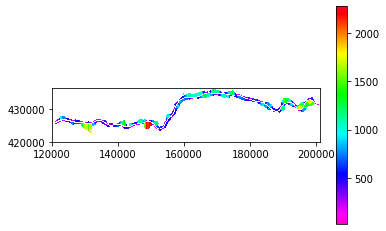

In [24]:
pcr.aguila(geom.main_channel_width)
pcr.plot(geom.flpl_width)

In [25]:
# close all aguila processes
!killall aguila

<br>

## Initiating the River and Its Measures

Given the aforementioned attributes, the River Waal and its current measured would be initiated by executing the following cells. 


In [26]:
# The River Wall is initiated based on the aforementioned given attributes.
waal = msr.River('Waal', axis, main_dike, minemb, groynes, hydro, 
                         mesh, lulc, geom)

In [33]:
# Initiate the Measures for the River.
waal_msr = msr.RiverMeasures(waal)

<br>

# Configuration for the Measures

The following properties are the default/setting configuration to the Measures.

In [34]:
# Default setting/configuration to the Measures.
settings = OrderedDict([
                    ('smoothing_percentage', 100),
                    ('smoothing_ecotope', 'UG-2'),
                    ('smoothing_trachytope', 1201),
                    
                    ('lowering_percentage', 100),
                    ('lowering_ecotope', 'UG-2'),
                    ('lowering_trachytope', 1201),
                    ('lowering_height', 'water_level_50d'),
                    
                    ('channel_width', 75),
                    ('channel_depth', 2.5),
                    ('channel_slope', 1./3.),
                    ('channel_ecotope', 'RnM'),
                    ('channel_trachytope', 105),
                    
                    ('relocation_alpha', 10000),
                    ('relocation_depth', 'AHN'),
                    ('relocation_ecotope', 'HG-2'),
                    ('relocation_trachytope', 1201),
                    
                    ('groyne_ref_level', 'wl_exc150d'),
                    ('minemb_ref_level', 'wl_exc50d'),
                    ('main_dike_dh', 0.50),
                    ])

<br>

## Make your own side channel properties:

You may want to modify the side channel properties using the followong interactive cell.

In [35]:
channel_values = channel_properties()

interactive(children=(IntSlider(value=50, description='Width [m]', max=200, min=5, step=5), FloatSlider(value=…

Load the following cells to use your configuration.

In [36]:
w = channel_values.kwargs['width']
s = channel_values.kwargs['slope']
d = channel_values.kwargs['depth']

print(w,s,d)

settings['channel_width'] = channel_values.kwargs['width']
settings['channel_depth'] = channel_values.kwargs['depth']
settings['channel_slope'] = channel_values.kwargs['slope']

print(settings)

50 2 1.0
OrderedDict([('smoothing_percentage', 100), ('smoothing_ecotope', 'UG-2'), ('smoothing_trachytope', 1201), ('lowering_percentage', 100), ('lowering_ecotope', 'UG-2'), ('lowering_trachytope', 1201), ('lowering_height', 'water_level_50d'), ('channel_width', 50), ('channel_depth', 1.0), ('channel_slope', 2), ('channel_ecotope', 'RnM'), ('channel_trachytope', 105), ('relocation_alpha', 10000), ('relocation_depth', 'AHN'), ('relocation_ecotope', 'HG-2'), ('relocation_trachytope', 1201), ('groyne_ref_level', 'wl_exc150d'), ('minemb_ref_level', 'wl_exc50d'), ('main_dike_dh', 0.5)])


In [37]:
# Put your setting/configuration to the Measures. 
waal_msr.settings = settings

In [38]:
# Default mask and ID
mask = pcr.boolean(1)
ID = 'everywhere'

In [39]:
# TODO: Make interactive input for selecting mask for every measure. 

In [40]:
# an example to select limited mask regions

# flpl_section = pcr.ifthen(large_sections == 1, pcr.nominal(1))
# mask = pcr.boolean(flpl_section)

# pcr.aguila(mask)
# pcr.plot(mask)

<br>

## Flood plain lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [41]:
large_sections = pcr.ifthen(pcr.areaarea(waal.geom.flpl_wide) > 1e6, pcr.boolean(1.0))
mask = pcr.boolean(large_sections)
ID = "large_sections"

In [42]:
# floodplain lowering measure
lowering_msr = waal_msr.lowering_measure(settings, mask=mask, ID=ID)

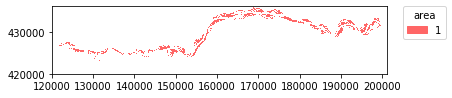

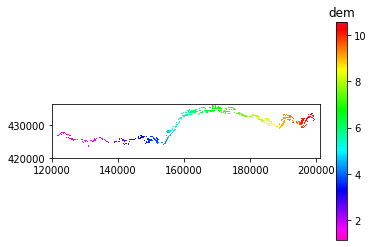

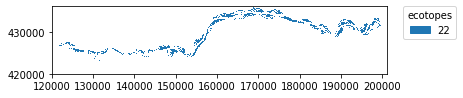

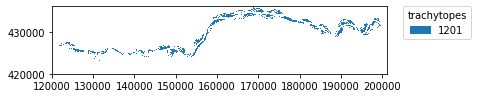

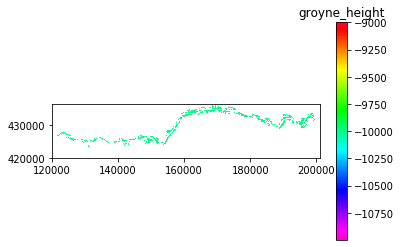

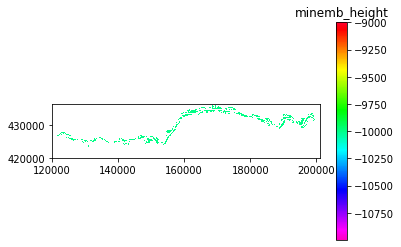

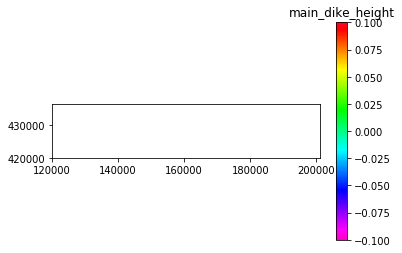

In [43]:
# plot/explore floodplain lowering measure
lowering_msr.plot()

In [44]:
# close all aguila processes 
!killall aguila

<br>

## Groyne lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [45]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [46]:
# groyne lowering measure
groyne_low_msr = waal_msr.groyne_lowering_msr(settings, mask=mask, ID=ID)

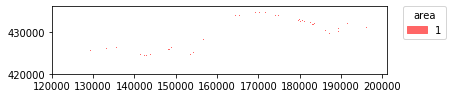

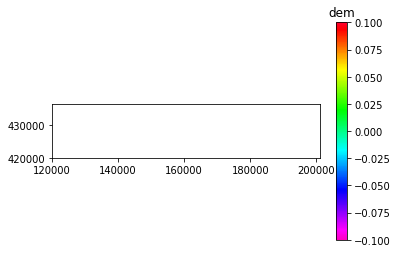

/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/sutan101/opt/anaconda2/envs/rs-env/lib/python3.6/site-packages/numpy/ma/

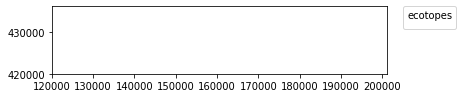

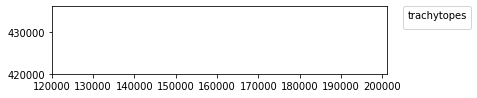

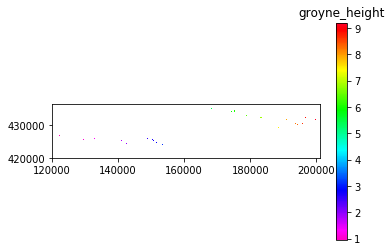

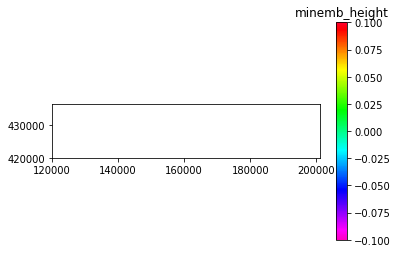

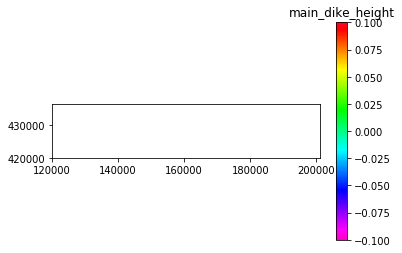

In [47]:
# plot/explore groyne lowering measure
groyne_low_msr.plot()

In [48]:
# close all aguila processes 
!killall aguila

<br>

## Minor embankment lowering measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [49]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [50]:
# measure by minor embankment lowering
minemb_low_msr = waal_msr.minemb_lowering_msr(settings, mask=mask, ID=ID)

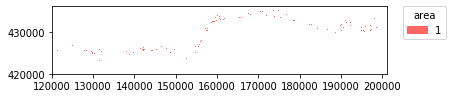

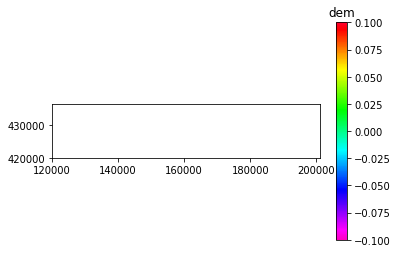

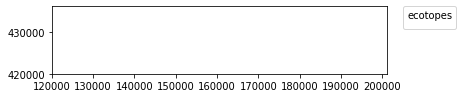

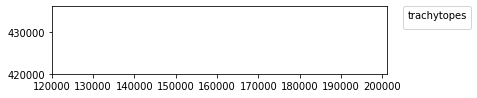

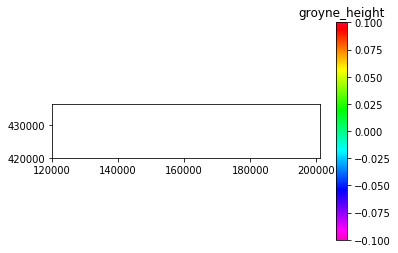

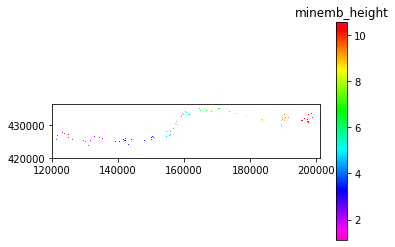

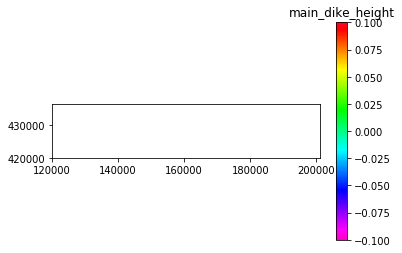

In [51]:
# plot/explore minor embankment lowering
minemb_low_msr.plot()

In [52]:
# close all aguila processes 
!killall aguila

<br>

## Main dike raising measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [53]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [54]:
# measure by main dike raising
main_dike_raise_msr = waal_msr.main_dike_raising_msr(settings, mask=mask, ID=ID)

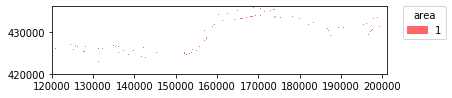

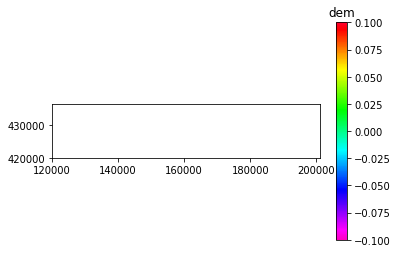

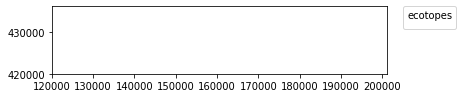

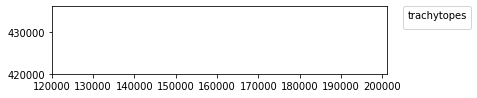

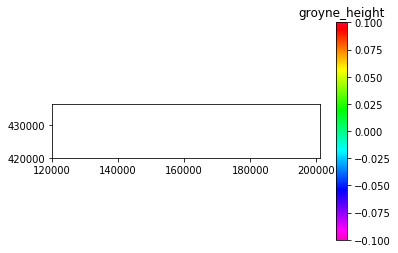

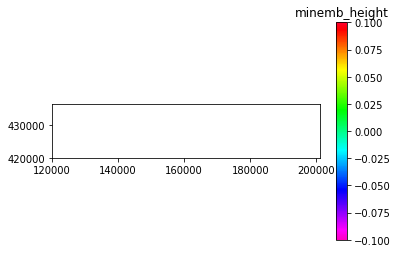

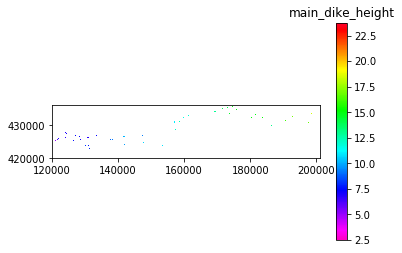

In [55]:
# plot/explore main dike raising measure
main_dike_raise_msr.plot()

In [56]:
# close all aguila processes 
!killall aguila

<br>

## Side channel measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [57]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [58]:
# measure by side channel constrcution
# - this includes looping over flood plain IDs
chan_msr = waal_msr.side_channel_measure(settings, mask=mask, ID=ID)

[1, 2, 3, 8, 10, 13, 14, 18, 20, 22, 23, 27, 30, 39, 40, 43, 49, 54, 56]
1
2
3
8
10
13
14
18
20
22
23
27
30
39
40
43
49
54
56


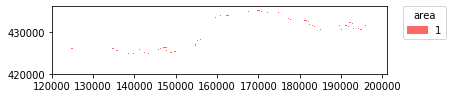

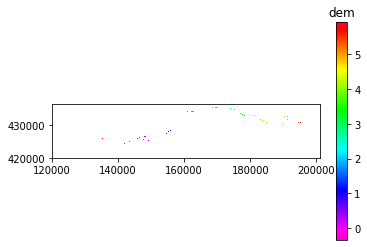

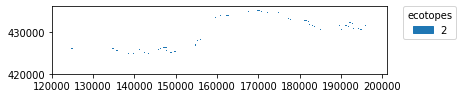

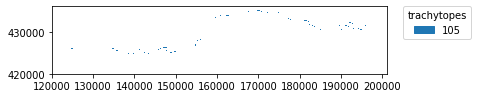

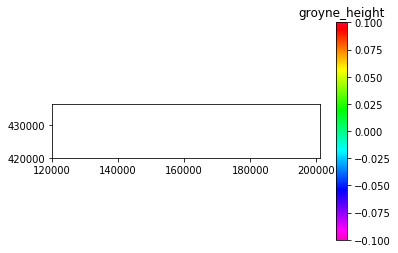

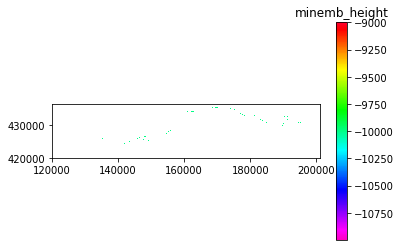

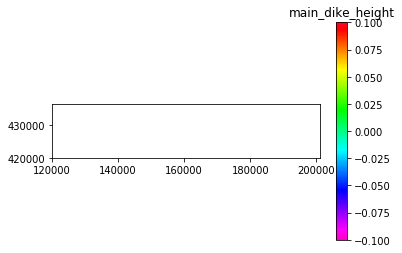

In [59]:
# plot/explore side channel measure
chan_msr.plot()

<br>

## Roughness smoothing measure:

Please set the ID/label for this measure and set the mask where you want to introduce this measure.   

In [60]:
mask = pcr.boolean(1)
ID = 'everywhere'

In [61]:
# measure by roughness smoothing
smooth_msr = waal_msr.smoothing_measure(settings, mask=mask, ID=ID)

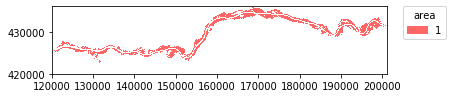

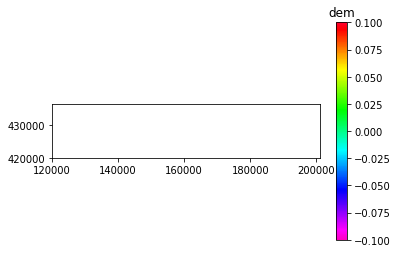

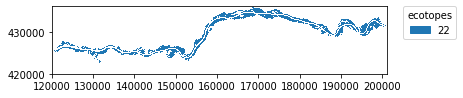

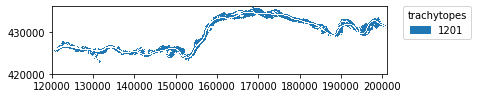

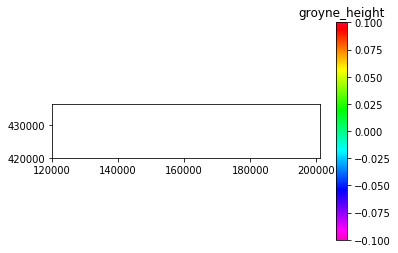

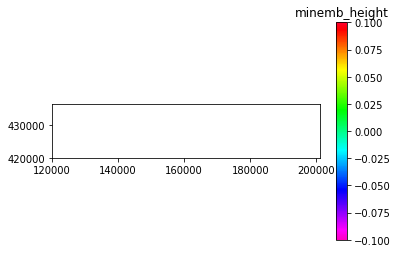

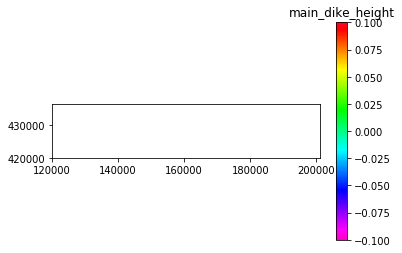

In [62]:
# plot/explore measure by roughness smoothing
smooth_msr.plot()

In [63]:
# close all aguila processes 
!killall aguila

Saving measures to the disk
========================

In [64]:
# list of measures
msr_list = [groyne_low_msr, minemb_low_msr,
            main_dike_raise_msr, lowering_msr, chan_msr, smooth_msr]
# - preparing the directory
msr_root_dir = os.path.join(output_dir, 'measures_ensemble03/maps')
pcrRecipes.make_dir(msr_root_dir)
for measure in msr_list:
    msr.write_measure(measure, msr_root_dir)

/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/groynelowering_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/minemblowering_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/dikeraising_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/lowering_large_sections
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/sidechannel_everywhere
/scratch/sutan101/tmp_menno_test/out/measures_ensemble03/maps/smoothing_everywhere
